<a href="https://colab.research.google.com/github/nitinsaimajji/voice/blob/main/voice_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install python_speech_features module

In [ ]:
pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=07202101789129a541ff63ede623d9a19c4849ee648dad50263c8ac6b008be13
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features


In [ ]:
!git clone https://github.com/nitinsaimajji/voice.git

Cloning into 'voice'...
remote: Enumerating objects: 1107, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 1107 (delta 3), reused 102 (delta 0), pack-reused 999
Receiving objects: 100% (1107/1107), 38.86 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all modules

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time

Load the csv file into data frame

In [ ]:
df = pd.read_csv('voice/cv-valid-train.csv')

Create two new data frames

In [ ]:
df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']


Find out the number of rows

In [ ]:
print(df_male.shape)		
# output: (55029, 8) 

(55029, 8)


In [ ]:
print(df_female.shape)		
print(df_female)
# output: (18249, 8)

(100, 8)
                              filename  \
5     cv-valid-train/sample-000005.mp3   
13    cv-valid-train/sample-000013.mp3   
26    cv-valid-train/sample-000026.mp3   
34    cv-valid-train/sample-000034.mp3   
39    cv-valid-train/sample-000039.mp3   
...                                ...   
1153  cv-valid-train/sample-001153.mp3   
1164  cv-valid-train/sample-001164.mp3   
1193  cv-valid-train/sample-001193.mp3   
1194  cv-valid-train/sample-001194.mp3   
1216  cv-valid-train/sample-001216.mp3   

                                                   text  up_votes  down_votes  \
5     a shepherd may like to travel but he should ne...         1           0   
13    but he had found a guide and didn't want to mi...         1           0   
26    two years ago right here on this spot i had a ...         4           0   
34              i have had the same dream twice he said         1           0   
39    a large piece suddenly came off and fell with ...         3           1   


Take only 300 male and 300 female data

In [ ]:
df_male = df_male[:100]
df_female = df_female[:100]
df_female

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
26,cv-valid-train/sample-000026.mp3,two years ago right here on this spot i had a ...,4,0,twenties,female,australia,NaN
34,cv-valid-train/sample-000034.mp3,i have had the same dream twice he said,1,0,fourties,female,us,NaN
39,cv-valid-train/sample-000039.mp3,a large piece suddenly came off and fell with ...,3,1,teens,female,canada,NaN
...,...,...,...,...,...,...,...,...
1153,cv-valid-train/sample-001153.mp3,the greatest authority on meteorites stated th...,4,0,sixties,female,us,NaN
1164,cv-valid-train/sample-001164.mp3,the time must have been somewhere around six o...,3,0,thirties,female,us,NaN
1193,cv-valid-train/sample-001193.mp3,the first rule of don't fight club is let's ta...,3,0,thirties,female,canada,NaN
1194,cv-valid-train/sample-001194.mp3,he told fatima that at their next meeting,1,0,sixties,female,canada,NaN


In [ ]:
df_female.to_csv('female.csv')

Define the audio path

In [ ]:
TRAIN_PATH = '/content/voice/cv-valid-train/'

The function to convert mp3 to wav

In [ ]:
def convert_to_wav(df, m_f, path=TRAIN_PATH):
    srcs = []
    for file in tqdm(df['filename']):
        sound = AudioSegment.from_mp3(path+file)
        
		# Create new wav files based on existing mp3 files
        if m_f == 'male':
            sound.export('male-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        elif m_f == 'female':
            sound.export('female-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        
    return

How to use the convert_to_wav() function

In [ ]:
convert_to_wav(df_male, m_f='male')


 85%|████████▌ | 85/100 [00:16<00:02,  5.02it/s]


FileNotFoundError: ignored

In [ ]:
convert_to_wav(df_female, m_f='female')

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Define a function to load the raw audio files

In [ ]:
def load_audio(audio_files):
	# Allocate empty list for male and female voices
    male_voices = []
    female_voices = []
    for file in tqdm(audio_files):
        if file.split('-')[0] == 'male':
            male_voices.append(librosa.load(file))
        elif file.split('-')[0] == 'female':
            female_voices.append(librosa.load(file))
    
	# Convert the list into Numpy array
    male_voices = np.array(male_voices)
    female_voices = np.array(female_voices)
    
    return male_voices, female_voices

How to use load_audio() function

In [ ]:
male_voices, female_voices = load_audio(os.listdir())

100%|██████████| 389/389 [01:39<00:00,  3.92it/s]
<ipython-input-47-77ae6b9e449c>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  male_voices = np.array(male_voices)
<ipython-input-47-77ae6b9e449c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  female_voices = np.array(female_voices)


The function to extract audio features

In [ ]:
def extract_features(audio_data):
	audio_waves = audio_data[:,0]
	samplerate = audio_data[:,1][1]
	
	features = []
	for audio_wave in tqdm(audio_waves):
		features.append(mfcc(audio_wave, samplerate=samplerate, numcep=26))
    
	features = np.array(features)
	return features

In [ ]:
print(male_voices[:,1][1])
print(male_voices.shape)

[array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1360781e-05,
        1.9946985e-05, 0.0000000e+00], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00014781,
        -0.00021482,  0.        ], dtype=float32)
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.1732135e-06,
        6.1608851e-05, 0.0000000e+00], dtype=float32)
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.4614171e-06,  1.7064467e-05,  0.0000000e+00], dtype=float32)
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.0939366e-07, -1.2034438e-07,  0.0000000e+00], dtype=float32)
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.2452439e-07,  1.2027940e-07,  0.0000000e+00], dtype=float32)
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.6625213e-06, -1.2229867e-05,  0.0000000e+00], dtype=float32)
 array([0.0000000e+00, 0.0000000e+00, 0.000000

Use the extract_features() function

In [ ]:
male_features = extract_features(male_voices)
female_features = extract_features(female_voices)

100%|██████████| 284/284 [00:05<00:00, 49.08it/s]
<ipython-input-103-1d3dd38f60c7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)
100%|██████████| 100/100 [00:02<00:00, 36.38it/s]


The function used to concatenate all audio features forming a long 2-dimensional array

In [ ]:
def concatenate_features(audio_features):
    concatenated = audio_features[0]
    for audio_feature in tqdm(audio_features):
        concatenated = np.vstack((concatenated, audio_feature))
        
    return concatenated

How the function is used

In [ ]:
male_concatenated = concatenate_features(male_features)
female_concatenated = concatenate_features(female_features)

100%|██████████| 100/100 [00:00<00:00, 1205.81it/s]


In [ ]:
print(male_concatenated.shape) 		
# Output: (117576, 26)

(111218, 26)


In [ ]:
print(female_concatenated.shape)	
# Output: (124755, 26)

(41245, 26)


Concatenate male voices and female voices

In [ ]:
X = np.vstack((male_concatenated, female_concatenated))
X

array([[-17.95160928, -19.52242461, -12.36131923, ...,  -0.11516822,
         -0.39050123,  -1.12977526],
       [-12.57271513,   4.61553396, -14.78240267, ...,  -0.29584838,
          0.82700792,   1.68380726],
       [-10.44658753,  13.00975796, -19.59755799, ...,  -0.07688046,
          0.73658424,   1.02138516],
       ...,
       [ -7.98527122,   0.91525817,   6.64830216, ...,  -0.18273626,
          0.93203027,   0.26786837],
       [ -8.83467273,   1.84733866,   5.90737929, ...,  -0.26424113,
          0.54983171,   0.0380893 ],
       [ -9.71939933,   1.28321873,   1.88294038, ...,  -0.13923801,
          0.80623467,   0.59314517]])

Create labels

In [ ]:
y = np.append([0] * len(male_concatenated), [1] * len(female_concatenated))
y

array([0, 0, 0, ..., 1, 1, 1])

Check whether X and y are already having the exact same length

In [ ]:
print(X.shape)		
# Output: (242268, 26)

[[-17.95160928 -19.52242461 -12.36131923 ...  -0.11516822  -0.39050123
   -1.12977526]
 [-12.57271513   4.61553396 -14.78240267 ...  -0.29584838   0.82700792
    1.68380726]
 [-10.44658753  13.00975796 -19.59755799 ...  -0.07688046   0.73658424
    1.02138516]
 ...
 [ -7.98527122   0.91525817   6.64830216 ...  -0.18273626   0.93203027
    0.26786837]
 [ -8.83467273   1.84733866   5.90737929 ...  -0.26424113   0.54983171
    0.0380893 ]
 [ -9.71939933   1.28321873   1.88294038 ...  -0.13923801   0.80623467
    0.59314517]]


In [ ]:
print(y.shape)		
# Output: (242268,)

(152463,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [ ]:
y_train.shape

(121970,)

Initialize SVM model

In [ ]:
clf = SVC(kernel='rbf')      

Train the model

In [ ]:
start = time()
model=clf.fit(X_train[:50000], y_train[:50000])
print(time()-start)						
# Output: 184.8018662929535 (seconds)

165.91033482551575


In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=262121 sha256=00ec78d1e91faf62199cf6870a42d639e798503094d02cca5ccc96549f7d1326
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


In [ ]:
import pickle5 as pickle
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(clf)
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
# Load the pickled model
model = pickle.loads(saved_model)

Compute the accuracy score towards train data

In [ ]:
start = time()
print(clf.score(X_train[:50000], y_train[:50000]))		
# Output: 0.78204

0.83466


In [ ]:
print(time()-start)						
# Output: 90.8693311214447 (seconds)

109.30222392082214


Compute the accuracy score towards test data

In [ ]:
start = time()
print(clf.score(X_test[:10000], y_test[:10000]))		
# Output: 0.7679

In [ ]:
print(time()-start)						
# Output: 18.082067728042603 (seconds)

Predict the first 10000 test data

In [ ]:
svm_predictions = clf.predict(X_test[:10000])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test[:10000],svm_predictions)*100
print("accuracy is "+str(accuracy))

accuracy is 82.07


Create the confusion matrix values

In [ ]:
cm = confusion_matrix(y_test[:10000], svm_predictions)

Create the confusion matrix display

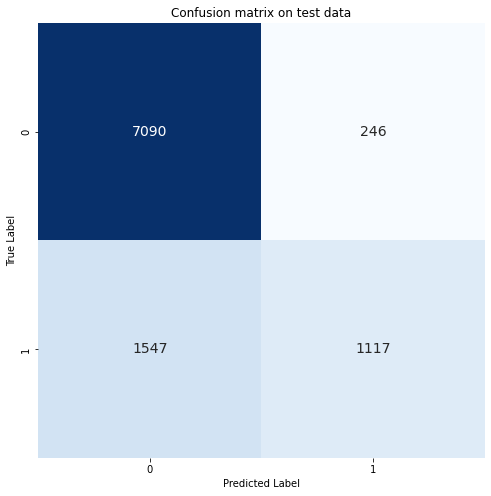

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', 
            cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Performance comparison between different algorithms

In [ ]:
! ls

drive			  male-sample-000111.wav  male-sample-000573.wav
female.csv		  male-sample-000115.wav  male-sample-000576.wav
female-sample-000005.wav  male-sample-000116.wav  male-sample-000577.wav
female-sample-000013.wav  male-sample-000118.wav  male-sample-000578.wav
female-sample-000026.wav  male-sample-000121.wav  male-sample-000579.wav
female-sample-000034.wav  male-sample-000132.wav  male-sample-000584.wav
female-sample-000039.wav  male-sample-000135.wav  male-sample-000591.wav
female-sample-000051.wav  male-sample-000137.wav  male-sample-000595.wav
female-sample-000057.wav  male-sample-000140.wav  male-sample-000600.wav
female-sample-000059.wav  male-sample-000146.wav  male-sample-000610.wav
female-sample-000077.wav  male-sample-000154.wav  male-sample-000612.wav
female-sample-000088.wav  male-sample-000167.wav  male-sample-000620.wav
female-sample-000101.wav  male-sample-000168.wav  male-sample-000622.wav
female-sample-000106.wav  male-sample-000175.wav  male-sample-000625.wav
female

In [ ]:
index = ['SVM-RBF', 'SVM-Poly', 'SVM-Sigmoid', 'Logistic Regression']

I record all the results below manually

In [ ]:
values = [184.8, 137.0, 283.6, 0.7]

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Training duration (lower is better)')
plt.xlabel('Seconds')
plt.ylabel('Model')
plt.barh(index, values, zorder=2)
plt.grid(zorder=0)

In [ ]:
for i, value in enumerate(values):
    plt.text(value+20, i, str(value)+' secs', fontsize=12, color='black',
             horizontalalignment='center', verticalalignment='center')

In [ ]:
plt.show()

set width of bar

In [ ]:
barWidth = 0.25
    
index = ['SVM-RBF', 'SVM-Poly', 'SVM-Sigmoid', 'Logistic Regression']

set height of bar<br>
I record all the results below manually

In [ ]:
train_acc = [78.2, 74.8, 74.8, 65.8]
test_acc = [76.8, 74.3, 74.3, 65.8]
 
# Set position of bar on X axis
baseline = np.arange(len(train_acc))
r1 = [x + 0.125 for x in baseline]
r2 = [x + 0.25 for x in r1]
 
# Make the plot
plt.figure(figsize=(16,9))
plt.title('Model performance (higher is better)')
plt.bar(r1, train_acc, width=barWidth, label='Train', zorder=2)
plt.bar(r2, test_acc, width=barWidth, label='Test', zorder=2)
plt.grid(zorder=0)
 
# Add xticks on the middle of the group bars
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth for r in range(len(train_acc))], index)

Create text

In [ ]:
for i, value in enumerate(train_acc):
    plt.text(i+0.125, value-5, str(value), fontsize=12, color='white',
             horizontalalignment='center', verticalalignment='center')
    
for i, value in enumerate(test_acc):
    plt.text(i+0.375, value-5, str(value), fontsize=12, color='white',
             horizontalalignment='center', verticalalignment='center')
    
plt.legend()
plt.sho

In [ ]:
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# print(loaded_model.predict(X_test[:10000]))
result = loaded_model.score(X_test[:10], y_test[:10])
print(result)

0.9


In [ ]:
predict=loaded_model.predict(X_test[:1])
print(predict)

[0]
accuracy is 0.0


In [ ]:
print(y_test[:5])

[1 0 0 0 0]
